In [1]:
import os
import json
import jieba
import jieba.analyse
import numpy as np
import pandas as pd
import csv
from datetime import datetime, timedelta

from collections import Counter
import uuid
import matplotlib.pyplot as plt

## 五、新闻关键词处理

### 5.1、数据预处理

#### 5.1.1、读取样本并格式化

In [2]:
news_data = []
# CSDC新闻文本数据文件路径
news_date_dir= './news/data'
i = 1
# 把源格式meta下的所有字段提取到上层。
for path in os.listdir(news_date_dir):
    news_date_path = os.path.join(news_date_dir, path)
    with open(news_date_path, 'r', encoding='utf-8') as news_file:
        news = json.load(news_file)
        for n in news:
            n['hour'] = int(n['time'].split()[1].split(':')[0])
            t= n['time'].split()[0].split('-')
            n['time'] = datetime(2020, int(t[0]),int(t[1]))
            n['content'] = n['meta']['content']
            n['description'] = n['meta']['description']
            n['keyword'] = ' '.join(n['meta']['keyword'])
            n['type'] = n['meta']['type']
            del n['meta']
            news_data.append(n)
print('新闻共{}条'.format(len(news_data)))

新闻共502550条


#### 5.1.2、转化DataFrame对象，补充缺失值

In [3]:
# 把上一小节中格式化的数据，转换为DataFrame对象，方便数据的处理
news_data = pd.DataFrame(news_data)
news_data = news_data.fillna('')
news_data.head()

,time,title,url,hour,content,description,keyword,type
0,2020-03-05,最高层再度发声释放9信号：5G再成重点 9行业迎风口,https://finance.sina.com.cn/stock/hyyj/2020-03...,0,高层定调新基建，七大板块迎风口！来新浪理财大学，听开年重磅专栏“交易日财经早报”。 最高层再...,最高层再度发声释放9信号：5G再成重点 9行业迎风口,应急物资 新冠肺炎,news
1,2020-03-05,东海证券前董事长被带走调查后 前总裁又被监管谈话,https://finance.sina.com.cn/stock/quanshang/qs...,0,炒股就看金麒麟分析师研报，权威，专业，及时，全面，助您挖掘潜力主题机会！ 原标题：这家券商怎...,东海证券前董事长被带走调查后 前总裁又被监管谈话,东海证券 券商,news
2,2020-03-05,海通姜超：注册制全面开启 债市有哪些影响？,https://finance.sina.com.cn/stock/stockzmt/202...,0,来源：姜超宏观债券研究 原标题：注册制全面开启，债市有哪些影响？（海通固收杜佳） 注册制全面...,海通姜超：注册制全面开启 债市有哪些影响？,发债 净资产,news
3,2020-03-05,A股突然火了：成全球资产避风港 这一特征更具吸引力,https://finance.sina.com.cn/stock/zqgd/2020-03...,0,高层定调新基建，七大板块迎风口！来新浪理财大学，听开年重磅专栏“交易日财经早报”。 原标题：...,A股突然火了：成全球资产避风港 这一特征更具吸引力,全球资产 中美 新冠肺炎,news
4,2020-03-05,工行招行平安备战基金投顾 如何能“投”会“顾”？,https://finance.sina.com.cn/stock/zqgd/2020-03...,0,原标题：牌照到手，工行招行平安备战基金投顾！如何能“投”会“顾”？模式理念业务架构统统要动 ...,工行招行平安备战基金投顾 如何能“投”会“顾”？,投顾 招行,news


#### 5.1.3、过滤空内容和去重

In [4]:
news_data = news_data.query("content != '' and url != ''")
len(news_data)

499945

In [5]:
news_data = news_data.drop_duplicates(subset=['url'])
len(news_data)

499649

#### 5.1.4、原有关键词观测

In [6]:
# 查看有多少新闻的关键词为空
print('缺失关键词的数据量为:', len(news_data.query("keyword == ''")))

缺失关键词的数据量为: 130451


样本未缺失的关键词分布如下：

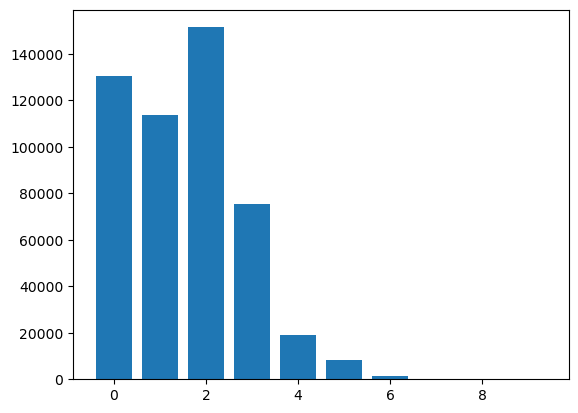

{0: 130451, 1: 113597, 2: 151427, 3: 75522, 4: 19083, 5: 8230, 6: 1267, 7: 61, 8: 7, 9: 4}


In [7]:
keyword_len = news_data['keyword'].map(lambda x: len(x.split(' ')) if x != '' else 0)
counter = Counter(keyword_len)
counter = {k:counter[k] for k in sorted(counter.keys())}
plt.bar(counter.keys(), counter.values())
plt.show()
print(counter)

In [40]:
news_data['keyword'].apply(lambda x: len(x)).describe(percentiles=[.25, .20, .80, .90] )

count    499649.000000
mean          5.605737
std           4.870365
min           0.000000
10%           0.000000
20%           0.000000
50%           5.000000
80%          10.000000
90%          12.000000
max          56.000000
Name: keyword, dtype: float64

#### 5.1.5、构造ID列辅助情感预测

考虑把新闻也作情感预测。按模型要求，构造一列UUID的ID列。

In [8]:
news_data['id'] = [uuid.uuid4() for _ in range(len(news_data))]
news_data['label'] = 0
news_data[['id', 'time', 'title', 'url', 'label']].head()

,id,time,title,url,label
0,91afa0cf-8de3-48ce-a067-3ebcabfb0eb7,2020-03-05,最高层再度发声释放9信号：5G再成重点 9行业迎风口,https://finance.sina.com.cn/stock/hyyj/2020-03...,0
1,96990cfa-ad79-401f-8b3a-c8958ff61465,2020-03-05,东海证券前董事长被带走调查后 前总裁又被监管谈话,https://finance.sina.com.cn/stock/quanshang/qs...,0
2,a6b71aa4-3c1b-4512-84dc-34fd376eb6d4,2020-03-05,海通姜超：注册制全面开启 债市有哪些影响？,https://finance.sina.com.cn/stock/stockzmt/202...,0
3,2e0b9188-efc7-4d0d-96cb-6c8d5f423253,2020-03-05,A股突然火了：成全球资产避风港 这一特征更具吸引力,https://finance.sina.com.cn/stock/zqgd/2020-03...,0
4,1d6a5462-e48e-4511-abbd-094b02dd877b,2020-03-05,工行招行平安备战基金投顾 如何能“投”会“顾”？,https://finance.sina.com.cn/stock/zqgd/2020-03...,0


因为ID列是新构造的，必须持久化保存，以方便模型预测出结果后根据ID来查找源数据。同时，也防止每次执行程序ID变动。
因为时间和算力的关系，新闻的情感预测只选择了前100天样本作比较。

In [29]:
# 保存ID化的数据集，后面可能要与评论的数据做联合统计和对比
news_data.to_csv(
        './news/output/news_all.csv',
        index=False, 
        quoting = csv.QUOTE_ALL,
        quotechar='"',
        encoding = 'utf-8')
# 保存前100天数据做预测
news_data.query("time<='2020-04-09'").to_csv(
        './news/output/news_100.csv',
        index=False, 
        quoting = csv.QUOTE_ALL,
        quotechar='"',
        encoding = 'utf-8')
# 按CCF_BDCI_2019的数据格式要求，保存前100天数据做预测
news_emotion = news_data.query("time<='2020-04-09'")[['id', 'title', 'content', 'label']]
news_emotion.to_csv(
        './news/output/news_emotion_test_100.csv',
        index=False, 
        quoting = csv.QUOTE_ALL,
        quotechar='"',
        encoding = 'utf-8')
len(news_data),len(news_emotion)

(499649, 207082)

### 5.2、关键词提取

#### 5.2.1、基于jieba的textrank算法提取关键词

提取关键词到一个新的列keyword_new中

In [9]:
def extract_keywords(text):
    # 基于jieba的textrank算法实现
    keywords = jieba.analyse.textrank(text,topK=6,withWeight=True)
    return ' '.join([keyword[0] for keyword in keywords])

In [10]:
news_data['keyword_new'] =news_data['content'].map(lambda x: extract_keywords(x))

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.393 seconds.
Prefix dict has been built successfully.


#### 5.2.2、保存提取关键词后的临时结果

In [13]:
# 保存提取关键词后的原文件
news_data.to_csv('./news/output/keyword_textrank.csv', sep='\t',
        index=False, 
        quoting = csv.QUOTE_ALL,
        quotechar='"',
        escapechar=',',
        encoding = 'utf-8')

In [14]:
# 保存提取关键词后的精简版，方便下一步合并关键词
keyword_data = news_data[['time','keyword','keyword_new']]
keyword_data.to_csv('./news/output/keyword.csv', sep='\t',
        index=False, 
        quoting = csv.QUOTE_ALL,
        quotechar='"',
        escapechar=',',
        encoding = 'utf-8')
keyword_data

,time,keyword,keyword_new
0,2020-03-05,应急物资 新冠肺炎,防控 疫情 方面 会议 包括 经济社会
1,2020-03-05,东海证券 券商,证券 东海 合规 管理 江苏 业务
2,2020-03-05,发债 净资产,发行 注册 融资 审核 机构 公司
3,2020-03-05,全球资产 中美 新冠肺炎,A股 市场 水平 资产 中国 存在
4,2020-03-05,投顾 招行,投顾 客户 基金 业务 银行 人士
...,...,...,...
502545,2020-08-09,李国庆 俞渝 父母代持,当当网 儿子 股份 父母 股权 代持
502546,2020-08-09,包月影视会员 消费陷阱 自动续费,开通 续费 消费者 支付 商家 取消
502547,2020-08-09,美国 华为 芯片,芯片 麒麟 手机 美国 产品 智能手机
502548,2020-08-09,印度 5G Jio,电信 设备 技术 运营商 平台 网络


#### 5.2.3、合并原有的、自动取提的关键词

In [16]:
keyword_data['keyword'] = keyword_data['keyword'].map(str).str.cat([keyword_data["keyword_new"]],sep=' ')
keyword_data['keyword'] = keyword_data['keyword'].map(lambda k: ' '.join(str(k).split(' ')[:6]))
keyword_data = keyword_data.drop(columns='keyword_new')
keyword_data

/tmp/ipykernel_33482/2108969814.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  keyword_data['keyword'] = keyword_data['keyword'].map(str).str.cat([keyword_data["keyword_new"]],sep=' ')
/tmp/ipykernel_33482/2108969814.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  keyword_data['keyword'] = keyword_data['keyword'].map(lambda k: ' '.join(str(k).split(' ')[:6]))


,time,keyword
0,2020-03-05,应急物资 新冠肺炎 防控 疫情 方面 会议
1,2020-03-05,东海证券 券商 证券 东海 合规 管理
2,2020-03-05,发债 净资产 发行 注册 融资 审核
3,2020-03-05,全球资产 中美 新冠肺炎 A股 市场 水平
4,2020-03-05,投顾 招行 投顾 客户 基金 业务
...,...,...
502545,2020-08-09,李国庆 俞渝 父母代持 当当网 儿子 股份
502546,2020-08-09,包月影视会员 消费陷阱 自动续费 开通 续费 消费者
502547,2020-08-09,美国 华为 芯片 芯片 麒麟 手机
502548,2020-08-09,印度 5G Jio 电信 设备 技术


### 5.3、 统计分析

#### 5.3.1、新闻数量按月统计走趋图

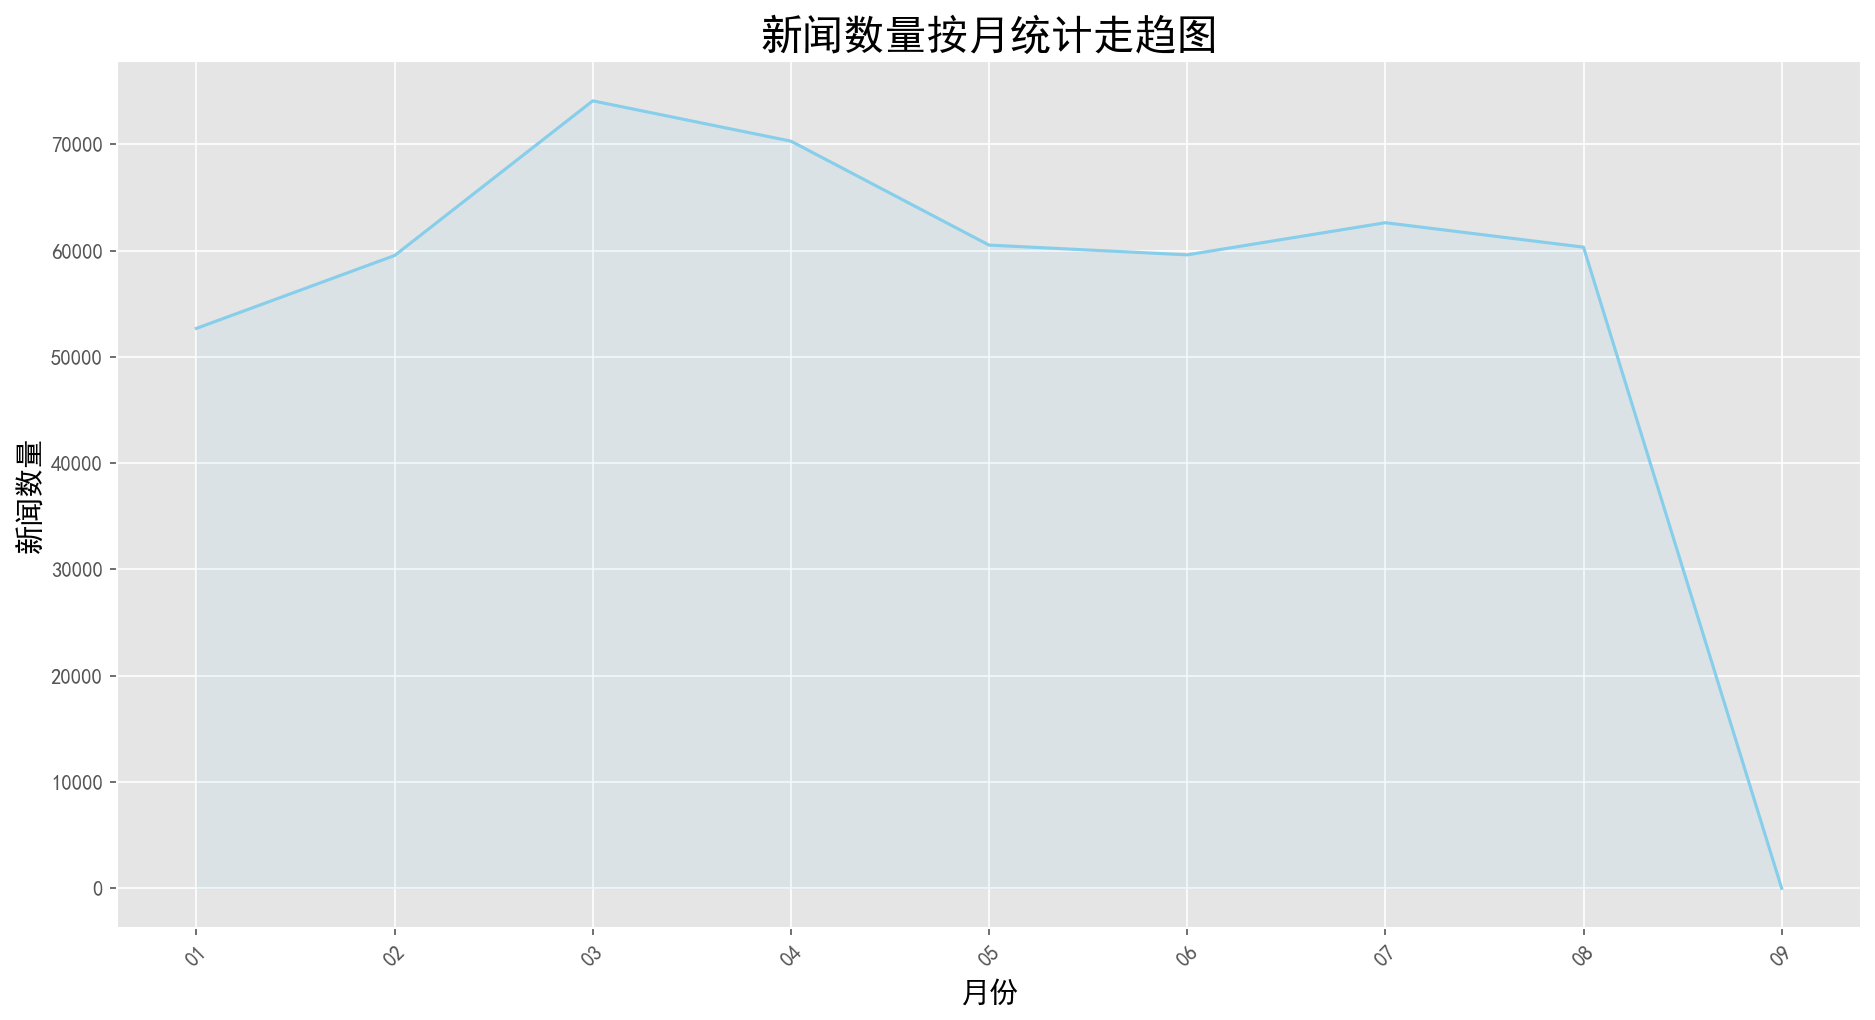

In [41]:
news_mouth = news_data.copy()
news_mouth['mouth'] =  news_mouth['time'].map(lambda t: str(t).split()[0].split('-')[1])
news_mouth =news_mouth.groupby('mouth')['id'].count().reset_index()

x=range(len(news_mouth))
y=news_mouth['id'].values
x_tick_label = news_mouth['mouth'].values
plt.figure(figsize=(15, 7.5), dpi=150)
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.style.use("ggplot")
plt.fill_between(x, y, color="skyblue", alpha=0.1)
plt.plot(x, y, color="skyblue")
plt.title("新闻数量按月统计走趋图", loc="center",size=20)
plt.xlabel("月份", size=14)
plt.xticks(x,labels = x_tick_label, rotation = 45)
plt.ylabel("新闻数量", size=14)
plt.show()

#### 5.3.2、新闻发文数量的时段分布

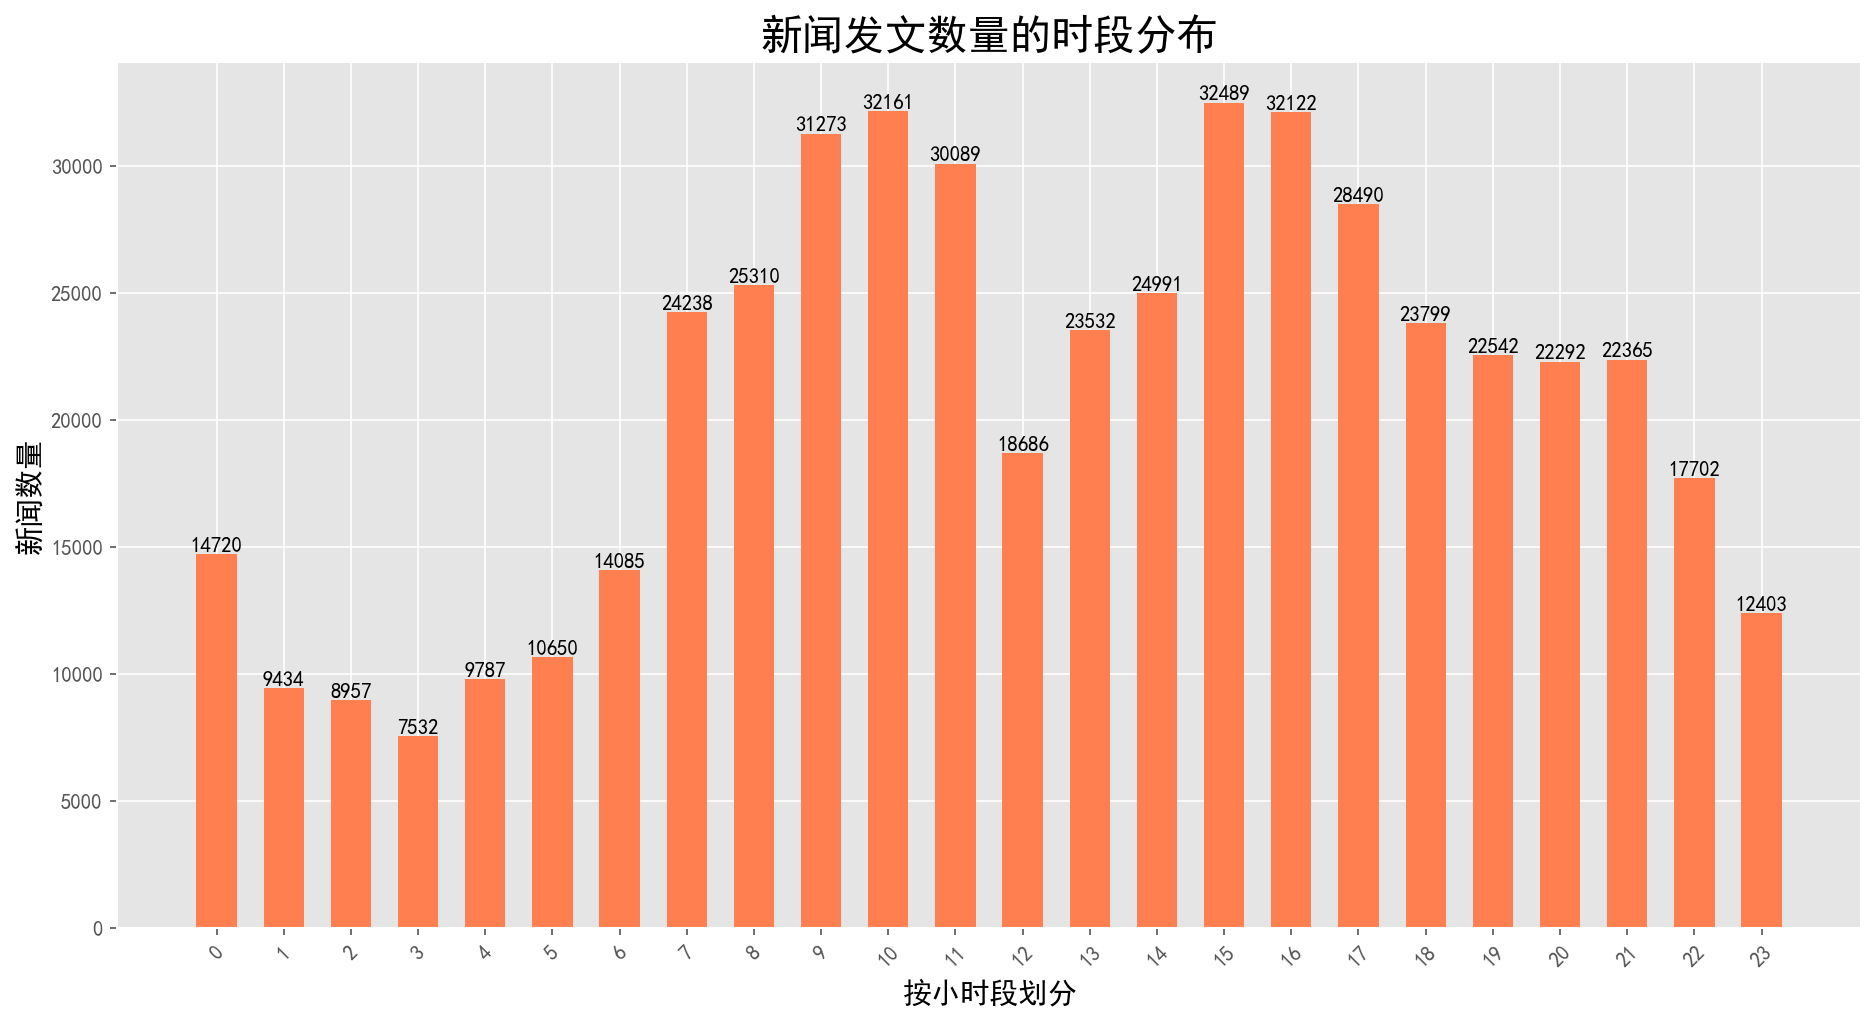

In [34]:
news_hour = news_data.copy()
news_hour = news_data.groupby('hour')['id'].count().reset_index()
news_hour

x=range(len(news_hour))
y=news_hour['id'].values
x_tick_label = news_hour['hour'].values
plt.figure(figsize=(15, 7.5), dpi=150)
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.style.use("ggplot")
bar = plt.bar(x, y, width= 0.6, color="coral") 
plt.bar_label(bar, label_type='edge') 
plt.title("新闻发文数量的时段分布", loc="center",size=20)
plt.xlabel("按小时段划分", size=14)
plt.xticks(x,labels = x_tick_label, rotation = 45)
plt.ylabel("新闻数量", size=14)
plt.show()


#### 5.3.3、新闻关键词的时段分布

In [30]:
keywords_hour = news_data[['time', 'hour', 'keyword', 'keyword_new']]

keywords_hour['keyword'] = keywords_hour['keyword'].map(str).str.cat([keywords_hour["keyword_new"]],sep=' ')
keywords_hour['keyword'] = keywords_hour['keyword'].map(lambda k: ' '.join(str(k).split(' ')[:6]))
keywords_hour = keywords_hour.drop(columns='keyword_new')
keywords_hour['mouth'] = pd.to_datetime(keywords_hour['time']).dt.month
keywords_hour

/tmp/ipykernel_33482/655272667.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  keywords_hour['keyword'] = keywords_hour['keyword'].map(str).str.cat([keywords_hour["keyword_new"]],sep=' ')
/tmp/ipykernel_33482/655272667.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  keywords_hour['keyword'] = keywords_hour['keyword'].map(lambda k: ' '.join(str(k).split(' ')[:6]))


,time,hour,keyword,mouth
0,2020-03-05,0,应急物资 新冠肺炎 防控 疫情 方面 会议,3
1,2020-03-05,0,东海证券 券商 证券 东海 合规 管理,3
2,2020-03-05,0,发债 净资产 发行 注册 融资 审核,3
3,2020-03-05,0,全球资产 中美 新冠肺炎 A股 市场 水平,3
4,2020-03-05,0,投顾 招行 投顾 客户 基金 业务,3
...,...,...,...,...
502545,2020-08-09,21,李国庆 俞渝 父母代持 当当网 儿子 股份,8
502546,2020-08-09,22,包月影视会员 消费陷阱 自动续费 开通 续费 消费者,8
502547,2020-08-09,8,美国 华为 芯片 芯片 麒麟 手机,8
502548,2020-08-09,12,印度 5G Jio 电信 设备 技术,8


In [35]:
keywords_hour_group = keywords_hour.groupby(['mouth','hour'])['keyword'].apply(lambda k: ' '.join(k)).reset_index()

keywords_hour_group['counter'] = keywords_hour_group['keyword'].map(lambda k: dict(Counter(k.split()).most_common(20)))
keywords_hour_group[['mouth','hour','counter']]

,mouth,hour,counter
0,1,0,"{'疫情': 195, '市场': 152, '公司': 146, '经济': 123, '..."
1,1,1,"{'疫情': 141, '市场': 108, '公司': 105, '中国': 84, '武..."
2,1,2,"{'公司': 97, '市场': 96, '中国': 69, '美国': 67, '疫情':..."
3,1,3,"{'中国': 100, '美国': 80, '市场': 72, '经济': 53, '公司'..."
4,1,4,"{'中国': 142, '发展': 132, '经济': 105, '市场': 96, '公..."
...,...,...,...
188,8,20,"{'新冠肺炎': 407, '公司': 376, '中国': 319, '美国': 302,..."
189,8,21,"{'新冠肺炎': 444, '公司': 389, '中国': 272, '美国': 252,..."
190,8,22,"{'新冠肺炎': 363, '公司': 334, '美国': 257, '中国': 230,..."
191,8,23,"{'新冠肺炎': 317, '美国': 197, '公司': 187, '中国': 161,..."


In [39]:
keywords_hour_group.to_csv('./news/output/keyword_hour_count.csv', 
                            index=False, 
                            quoting = csv.QUOTE_ALL,
                            quotechar='"',
                            encoding = 'utf-8')

#### 5.3.4、按周统计关键词7天累计量

滚动累计前7天内的关键词出现词频，取Top20，按天构造成字典：

In [17]:
news_time= datetime(2020, 1,1)
keywords_dic = {}
while news_time <= datetime(2020, 9, 1):
    news_time_start = news_time - timedelta(days=7)

    keyword_data_week = keyword_data.query("'{}'<time & time <='{}'".format(str(news_time_start), str(news_time)))

    keyword_list =' '.join(i for i in keyword_data_week['keyword'])
    
    keywords_dic[news_time.strftime('%Y-%m-%d')] = dict(Counter(keyword_list.split()).most_common(20))

    news_time +=timedelta(days=1)

with open('./web/data/keywords.json', 'w') as f:
    json.dump(keywords_dic, f)
print(keywords_dic)

{'2020-01-01': {'中国': 114, '经济': 98, '市场': 90, '降准': 72, '公司': 71, '美国': 66, '发展': 63, '企业': 36, '货币政策': 36, '资金': 34, '日本': 33, '基金': 31, '央行': 28, '银行': 27, '投资': 25, '没有': 25, '香港': 24, '国家': 24, '金融': 22, '指数': 21}, '2020-01-02': {'公司': 337, '中国': 298, '市场': 295, '经济': 232, '美国': 193, '降准': 159, '企业': 143, '发展': 134, '资金': 132, '日本': 129, '投资': 124, '银行': 105, '基金': 87, '股份': 87, '集团': 77, '产品': 77, '小米': 74, '货币政策': 73, '央行': 69, '业务': 68}, '2020-01-03': {'公司': 648, '市场': 479, '中国': 453, '美国': 400, '经济': 343, '伊朗': 291, '企业': 258, '投资': 217, '发展': 208, '资金': 206, '日本': 203, '降准': 182, '银行': 160, '产品': 156, '基金': 156, '股份': 155, '集团': 140, '小米': 126, '行业': 121, '服务': 114}, '2020-01-04': {'公司': 747, '市场': 554, '美国': 534, '中国': 532, '伊朗': 476, '经济': 393, '企业': 311, '发展': 259, '投资': 252, '日本': 232, '资金': 224, '降准': 186, '银行': 184, '基金': 178, '产品': 172, '股份': 162, '行业': 148, '集团': 146, '小米': 137, '服务': 131}, '2020-01-05': {'公司': 816, '伊朗': 689, '美国': 664, '市场': 607, '中国': 578, '经济': 42

#### 5.3.5、绘制关键词变化动态图
根据上面的按天构造的字典，使用echart绘制关键词变化动态图。代码及结果见 news_keyword.html (需webserver服务)